In [ ]:
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download nileshmalode1/samsum-dataset-text-summarization


mkdir: cannot create directory ‘/root/.kaggle’: File exists
 63% 5.00M/7.99M [00:00<00:00, 29.4MB/s]
100% 7.99M/7.99M [00:00<00:00, 42.4MB/s]


In [ ]:
# ! unzip samsum-dataset-text-summarization.zip


Archive:  samsum-dataset-text-summarization.zip
  inflating: samsum-test.csv         
  inflating: samsum-train.csv        
  inflating: samsum-validation.csv   
  inflating: samsum_dataset/dataset_dict.json  
  inflating: samsum_dataset/test/data-00000-of-00001.arrow  
  inflating: samsum_dataset/test/dataset_info.json  
  inflating: samsum_dataset/test/state.json  
  inflating: samsum_dataset/train/data-00000-of-00001.arrow  
  inflating: samsum_dataset/train/dataset_info.json  
  inflating: samsum_dataset/train/state.json  
  inflating: samsum_dataset/validation/data-00000-of-00001.arrow  
  inflating: samsum_dataset/validation/dataset_info.json  
  inflating: samsum_dataset/validation/state.json  


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/content/samsum_dataset'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
!pip install datasets -q
!pip install transformers -q
!pip install py7zr -q

In [ ]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from transformers import pipeline

In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
split_lengths

[14732, 819, 818]

In [ ]:
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
#pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

pipe = pipeline('summarization', model = 'facebook/bart-large-xsum')

In [ ]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Summary:
A few days ago, I was talking to my friend Hannah, and we were looking for her friend Betty.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#model_ckpt = "google/pegasus-cnn_dailymail"
model_ckpt='facebook/bart-large-xsum'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1081 > 1024). Running this sequence through the model will result in indexing errors


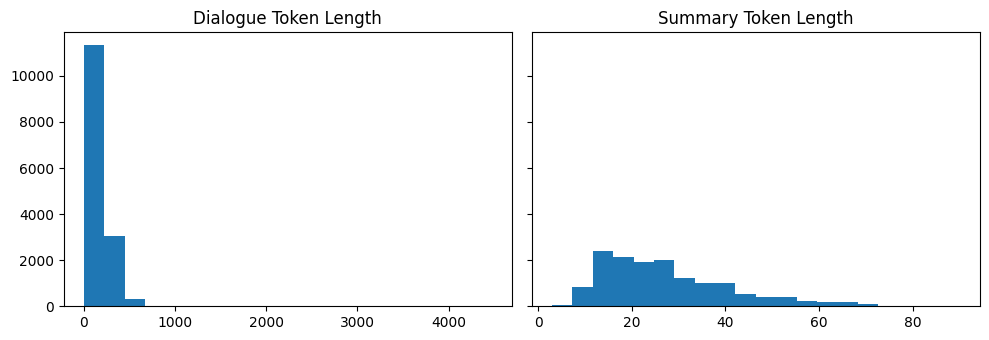

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Dialogue Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary Token Length")
plt.tight_layout()
plt.show()

In [ ]:
tokenizer.as_target_tokenizer()

In [ ]:
#lets tokenize the dataset

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

In [ ]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
!pip install accelerate -U -q
!pip install transformers[torch] -q

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="bart",
                                 num_train_epochs=1,
                                 warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_gpu_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10,
                                 push_to_hub=True,
                                 evaluation_strategy='steps',
                                 eval_steps=500,
                                 save_steps=1e6,
                                 gradient_accumulation_steps=16,
                                 report_to="none")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer = Trainer(model=model,
                 args=training_args,
                 tokenizer=tokenizer,
                 data_collator=seq2seq_data_collator,
                 train_dataset=dataset_samsum_pt["train"],
                 eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.458600,1.468044


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


TrainOutput(global_step=920, training_loss=1.4715023745661195, metrics={'train_runtime': 2274.509, 'train_samples_per_second': 6.477, 'train_steps_per_second': 0.404, 'total_flos': 4938562616451072.0, 'train_loss': 1.4715023745661195, 'epoch': 1.0})

In [ ]:
trainer.push_to_hub("Training complete.")

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/ndvhareesh/bart/tree/main/'

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "ndvhareesh/bart"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
!pip install rouge_score -q

  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import load_metric
from tqdm import tqdm

rouge_metric = load_metric("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

<ipython-input-7-f0b9cdcd6784>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


In [ ]:
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [ ]:
def evaluate_summaries(dataset, metric, model, tokenizer, batch_size=16, device=device,
                                   column_text="article",
                                   column_summary="highlights"):

    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
            inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                            padding="max_length", return_tensors="pt")
            print(type(article_batch))
            summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                             attention_mask=inputs["attention_mask"].to(device),
                             length_penalty=0.8, num_beams=8, max_length=128)
            decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                    clean_up_tokenization_spaces=True) for s in summaries]

            decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
            metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()

    return score

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
score = evaluate_summaries(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

In [ ]:
pd.DataFrame.from_records(rouge_dict, index=[f"samsum-bart"])

,rouge1,rouge2,rougeL,rougeLsum
samsum-bart,0.500678,0.265096,0.423002,0.423088


In [ ]:
gen_kwargs = {"length_penalty": 0.8,
             "num_beams": 8,
             "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model=model_ckpt)

In [ ]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda is looking for Betty's number. Larry called Betty the last time they were at the park. Hannah doesn't know him well.


In [ ]:
custom_dialogue = """\
Hary: Hi guys, have you heard of transformers?
Hamilton: Yes, I used them recently!
Lucy: Indeed, there is a great library by Hugging Face.
Hary: I know, I helped build it ;)
Hamilton: Cool, maybe we should write a book about it. What do you think? Lucy: Great idea, how hard can it be?!
Hary: I am in!
Hamilton: Awesome, let's do it together!
"""

print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)


Hary, Hamilton and Lucy are going to write a book about transformers.


In [ ]:
#THE END